#CODE FOR AUGMENT DATA (resize and x4)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing as tfl
import numpy as np
from cv2 import imread, imwrite
from os.path import join
from os import listdir

def data_augmentor(input, num_out=1,
                   save=False, image_name=None, save_format='jpg',
                   save_folder=None, output_shape=224, img_count=0):
    if input is None:
        raise ValueError('Input image is None. Please check image loading.')

    augmentation_pipeline = tf.keras.Sequential([
        tfl.RandomFlip('horizontal_and_vertical'),
        tfl.RandomRotation(0.5, fill_mode='wrap'),
        tfl.RandomZoom(0.2, fill_mode='reflect'),
        tfl.Resizing(288, 288),
        tfl.CenterCrop(output_shape, output_shape),
        tfl.RandomContrast(0.2)
    ])

    (_, _, c) = input.shape
    output = np.zeros((num_out, output_shape, output_shape, c))
    img_count = img_count

    for i in range(num_out):
        augmented_image = augmentation_pipeline(input)
        output[i] = augmented_image

        if save and image_name and save_folder:
            augmented_image = augmented_image.numpy().astype('uint8')
            saved_name = f'{image_name}_{str(img_count).zfill(5)}.{save_format}' # {name of vege}_{number},jpg
            try:
                imwrite(join(save_folder, saved_name), augmented_image)
                img_count += 1
            except Exception as e:
                print(f"Error saving {saved_name}: {e}")
        elif save and (not image_name or not save_folder):
            raise ValueError('Please provide image_name and save_folder')

    return output

def data_augmentor_list(input, num_out=1,
                        save=False, image_name=None, save_format='jpg',
                        save_folder=None, output_shape=224):
    if input is None or len(input) == 0:
        raise ValueError('Input list of images is empty or None.')

    num = len(input)
    (_, _, c) = input[0].shape
    output = np.zeros((num, num_out, output_shape, output_shape, c))
    img_count = 0

    for i, image in enumerate(input):
        if image is None:
            continue  # Skip None images

        output[i] = data_augmentor(
            input=image, num_out=num_out,
            save=save, image_name=image_name,
            save_format=save_format, save_folder=save_folder,
            output_shape=output_shape, img_count=img_count
        )
        img_count += num_out

    return output

def list_img_from_folder(folder_path, max_images=None):
    images = []
    count = 0
    for file_name in listdir(folder_path):
        if max_images is not None and count >= max_images:
            break
        loaded_img = imread(join(folder_path, file_name))
        if loaded_img is not None:
            images.append(loaded_img)
            count += 1
    return images

# Example usage
folder_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/Tia_to_ _perilla/Bad'
list_img = list_img_from_folder(folder_path, max_images=600) #you can change the max images for using purpose

save_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/Kinh_gioi_ _vietnamese_balm/Label' # where all label image is save
name = '6tiato' # name of image
augmented_imgs = data_augmentor_list(
    input=list_img, num_out=4, save=True,
    image_name=name, save_folder=save_path
) #You can change num_out to edit the number of image you want

# Liệt kê số lượng ảnh trong thư mục Label
num_images = len(listdir(save_path))
print(f"Tổng số lượng ảnh trong thư mục Label: {num_images}")


Tổng số lượng ảnh trong thư mục Label: 1600


In [ ]:
num_images = len(listdir(save_path))
print(f"Tổng số lượng ảnh trong thư mục Label: {num_images}")


Tổng số lượng ảnh trong thư mục Label: 2397


#CODE FOR LABELING

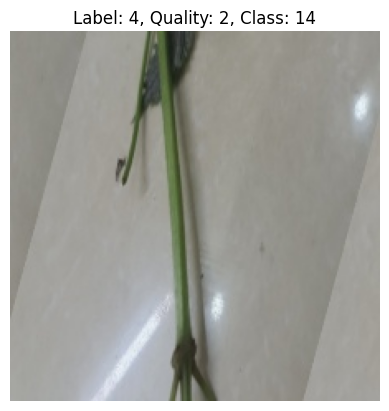

Total number of images in HDF5 file: 1600


In [ ]:
import os
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
from os.path import join

def save_images_to_h5(folder_path, output_h5_path, label=0, quality=0, class_label=0):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    images = []
    labels = []
    qualities = []
    classes = []

    for image_file in image_files:
        image_path = join(folder_path, image_file)
        image = cv2.imread(image_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        images.append(image)
        labels.append(label)
        qualities.append(quality)
        classes.append(class_label)

    images = np.array(images)
    labels = np.array(labels)
    qualities = np.array(qualities)
    classes = np.array(classes)

    with h5py.File(output_h5_path, 'w') as h5f:
        h5f.create_dataset('images', data=images)
        h5f.create_dataset('labels', data=labels)
        h5f.create_dataset('qualities', data=qualities)
        h5f.create_dataset('class', data=classes)

def show_random_image_from_h5(h5_path):
    with h5py.File(h5_path, 'r') as hf:
        num_images = len(hf['images'])
        random_index = random.randint(0, num_images - 1)

        image = hf['images'][random_index]
        label = hf['labels'][random_index]
        quality = hf['qualities'][random_index]
        class_label = hf['class'][random_index]

        plt.imshow(image)
        plt.title(f"Label: {label}, Quality: {quality}, Class: {class_label}")
        plt.axis('off')
        plt.show()

        return num_images

# Set paths
folder_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/Kinh_gioi_ _vietnamese_balm/Label'
output_h5_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/Tia_to_ _perilla/bad_TT.h5'

# Save images to a single HDF5 file
save_images_to_h5(folder_path, output_h5_path, label=4, quality=2, class_label=14) #NOTE: you should remember the label before run, change the value to suitable

# Show number of images and a random image with its label, quality, and class
num_images = show_random_image_from_h5(output_h5_path)
print(f"Total number of images in HDF5 file: {num_images}")


In [ ]:
#You can use this block when you want to change one label to another value
import h5py

def update_qualities(h5_path, old_value, new_value):
    with h5py.File(h5_path, 'r+') as hf:
        qualities = hf['qualities'][:]
        qualities[qualities == old_value] = new_value
        hf['qualities'][...] = qualities
        print(f"Đã cập nhật {old_value} thành {new_value} trong 'qualities'")

# Path to the HDF5 file
h5_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/Rau_ngot_ _katuk/good_RG.h5'

# Update the qualities from 1 to 2
update_qualities(h5_path, old_value=1, new_value=0)


Đã cập nhật 1 thành 0 trong 'qualities'


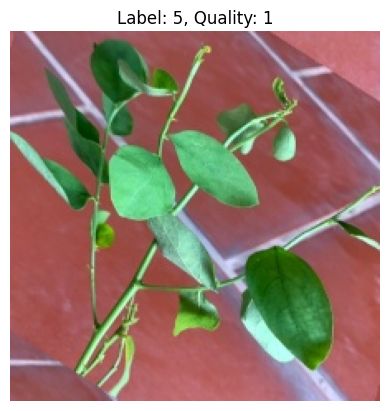

In [ ]:
#Show random image with its label of a specified h5 file to check the image and label are correct or not
import h5py
import matplotlib.pyplot as plt
import random

def show_random_image_with_class(h5_path):
    with h5py.File(h5_path, 'r') as hf:
        num_images = len(hf['images'])
        random_index = random.randint(0, num_images - 1)

        image = hf['images'][random_index]
        label = hf['labels'][random_index]
        quality = hf['qualities'][random_index]

        plt.imshow(image)
        plt.title(f"Label: {label}, Quality: {quality}")
        plt.axis('off')
        plt.show()

# Path to the HDF5 file
h5_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/Rau_ngot_ _katuk/average_RG.h5'

# Show a random image with its class label
show_random_image_with_class(h5_path)


#MERGE H5

In [ ]:
import h5py
import os
import numpy as np

def merge_h5_files(vegetable_folders, output_h5_path):
    all_images = []
    all_labels = []
    all_qualities = []
    all_classes = []

    for vegetable_folder in vegetable_folders:
        h5_files = [f for f in os.listdir(vegetable_folder) if f.endswith('.h5')]

        for h5_file in h5_files:
            h5_path = os.path.join(vegetable_folder, h5_file)
            print(f"Processing file: {h5_path}")  # Debugging line
            with h5py.File(h5_path, 'r') as hf:
                images = np.array(hf['images'])
                labels = np.array(hf['labels'])
                qualities = np.array(hf['qualities'])
                classes = np.array(hf['class'])

                all_images.append(images)
                all_labels.append(labels)
                all_qualities.append(qualities)
                all_classes.append(classes)

    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_qualities = np.concatenate(all_qualities, axis=0)
    all_classes = np.concatenate(all_classes, axis=0)

    print(f"Total images: {len(all_images)}")  # Debugging line
    print(f"Total labels: {len(all_labels)}")  # Debugging line
    print(f"Total qualities: {len(all_qualities)}")  # Debugging line
    print(f"Total classes: {len(all_classes)}")  # Debugging line

    with h5py.File(output_h5_path, 'w') as hf:
        hf.create_dataset('images', data=all_images)
        hf.create_dataset('labels', data=all_labels)
        hf.create_dataset('qualities', data=all_qualities)
        hf.create_dataset('class', data=all_classes)

    return len(all_images)

def show_number_of_images_in_h5(h5_path):
    with h5py.File(h5_path, 'r') as hf:
        num_images = len(hf['images'])
    return num_images

# Define the root folder and output folder
root_folder = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data'
vegetable_folders = [
    os.path.join(root_folder, 'Kinh_gioi_ _vietnamese_balm'),
    os.path.join(root_folder, 'La_lot_ _piper_lolot'),
    os.path.join(root_folder, 'Mo_long _Mo_tron_ _Paederia_foetida'),
    os.path.join(root_folder, 'Rau_muong_ _water_morning_glory'),
    os.path.join(root_folder, 'Rau_ngot_ _katuk'),
    os.path.join(root_folder, 'Tia_to_ _perilla')
]

# Merge HDF5 files for all vegetable folders into one HDF5 file
output_h5_path = os.path.join(root_folder, 'hierachical_5_3_224x224_30072.h5')
num_images = merge_h5_files(vegetable_folders, output_h5_path)
print(f"Total number of images in {output_h5_path}: {num_images}")


Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/Kinh_gioi_ _vietnamese_balm/good_KG.h5
Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/Kinh_gioi_ _vietnamese_balm/average_KG.h5
Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/Kinh_gioi_ _vietnamese_balm/bad_KG.h5
Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/La_lot_ _piper_lolot/bad_LL.h5
Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/La_lot_ _piper_lolot/average_LL.h5
Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/La_lot_ _piper_lolot/good_LL.h5
Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/Mo_long _Mo_tron_ _Paederia_foetida/average_ML.h5
Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/Mo_long _Mo_tron_ _Paederia_foetida/good_ML.h5
Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/Mo_long _Mo_tron_ _Paederia_foetida/bad_ML.h5
Processing file: /content/drive/MyDrive/DAP391m_G06_AI1807/Data/

#CODE FOR READ H5 AND CHECK ALL VALUE OF LABEL

In [ ]:
import h5py

def check_unique_labels_and_qualities(h5_path):
    with h5py.File(h5_path, 'r') as hf:
        labels = hf['labels'][:]
        qualities = hf['qualities'][:]

        unique_labels = set(labels)
        unique_qualities = set(qualities)

        print(f"Number of unique labels: {len(unique_labels)}")
        print(f"Unique labels: {unique_labels}")

        print(f"Number of unique qualities: {len(unique_qualities)}")
        print(f"Unique qualities: {unique_qualities}")

# Path to your HDF5 file
h5_path = '/content/drive/MyDrive/DAP391m_G06_AI1807/Data/4label.h5'

# Check number of unique labels and qualities
check_unique_labels_and_qualities(h5_path)


Number of unique labels: 4
Unique labels: {0, 1, 2, 3}
Number of unique qualities: 3
Unique qualities: {0, 1, 2}
